## Exploratory Data Analysis

As with any new dataset, we should look at the data to try and get a feel for the problem we're solving. In particular we have a few questions:
 - What do the images look like?
 - What do the bounding boxes look like?
 - What do the test images look like? Are they different than our training set?

In [31]:
import os
import collections
import numpy as np
from fastai.vision import Path, open_image, ImageBBox

In [32]:
DATA = Path('data/')
IMAGES = DATA/'train_labelled_images'
ANNOTATIONS = DATA/'train_labelled_annotations'

In [6]:
# Based off fastai's get_annotations()
def get_annotations_from_path(folderPath, prefix=None):
    "Open the files in folder `folderPath` and returns the lists of filenames (with maybe `prefix`) and labelled bboxes."
    filePaths = os.listdir(folderPath)     
    id2images, id2bboxes, id2cats = {}, collections.defaultdict(list), collections.defaultdict(list)
    classes = {}
    
    sorghumHeadCategory = 0
    
    for path in filePaths:
        fullPath = folderPath/path
        id = path.replace('.txt', '.jpeg')
        
        with open(fullPath, 'r') as f:
            for line in f:
                
                splitLines = line.split(' ')
                
                left = int(splitLines[1])
                top = int(splitLines[2])
                right = int(splitLines[3])
                bottom = int(splitLines[4].strip())
               
                #Coco format: "bbox" : [x,y,width,height]
                #Converted "bbox" : [left,top,width,height]
                #id2bboxes[o['image_id']].append([bb[1],bb[0], bb[3]+bb[1], bb[2]+bb[0]])

                id2bboxes[id].append([top, left, bottom, right])
                id2cats[id].append(sorghumHeadCategory)
               
            id2images[id] = IMAGES/id

    #Set up classes mapping from id to classname
    classes[sorghumHeadCategory] = 'sorghumHead'
                   
    ids = list(id2images.keys())
    return [id2images[k] for k in ids], [[id2bboxes[k], id2cats[k]] for k in ids]

In [8]:
images, lbl_bbox = get_annotations_from_path(ANNOTATIONS)

Let's start by taking a look at the images

torch.Size([1259, 312])


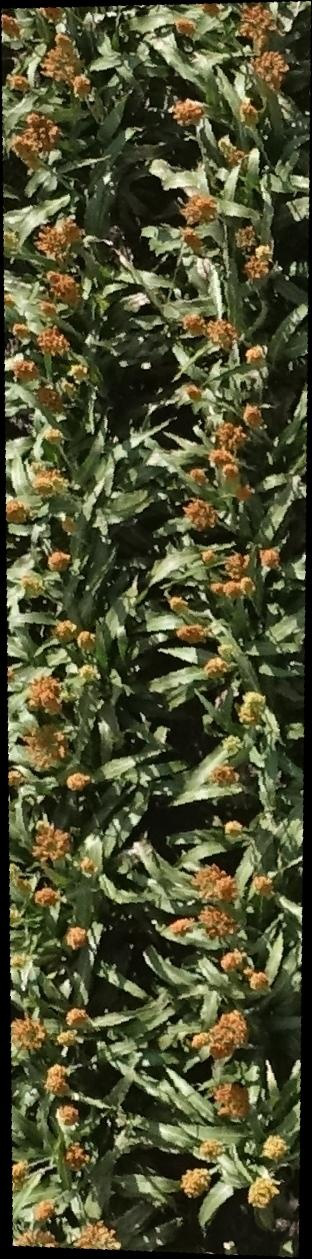

In [13]:
img = open_image(images[0])
print(img.size)
img

torch.Size([1280, 329])


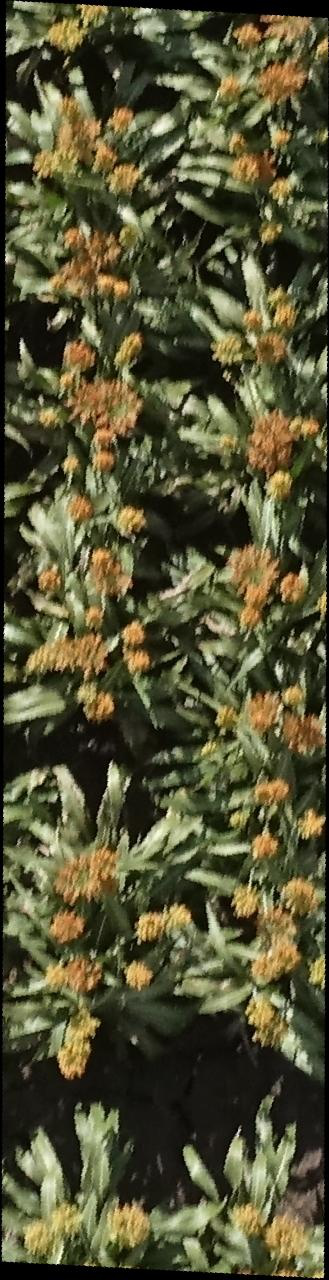

In [15]:
img = open_image(images[1])
print(img.size)
img

So our images appear to be long vertical strips with flowers. Some of the images appear to be blurry.

Let's calculate the average, max and min for the dimensions of our images.

In [35]:
def image_stats_for_folder(folderPath):
    filePaths = os.listdir(folderPath)
    
    heights = np.zeros((len(filePaths),))
    widths = np.zeros((len(filePaths),))
     
    for i, path in enumerate(filePaths):
        
        image = open_image(folderPath/path)
        heights[i] = image.size[0]
        widths[i] = image.size[1]
        
    meanHeight = heights.mean()
    meanWidth = widths.mean()
    
    stdHeight = heights.std()
    stdWidth = widths.std()
    
    maxHeight = heights.max()
    maxWidth = widths.max()
    
    minHeight = heights.min()
    minWidth = widths.min()
    
    return meanHeight, meanWidth, stdHeight, stdWidth, maxHeight, maxWidth, minHeight, minWidth

In [40]:
meanHeight, meanWidth, stdHeight, stdWidth, maxHeight, maxWidth, minHeight, minWidth = image_stats_for_folder(IMAGES)

print("Mean Height", meanHeight)
print("Std Height", stdHeight)
print("Max Height", maxHeight)
print("Min Height", minHeight)
print()
print("Mean Width", meanWidth)
print("Std Width", stdWidth)
print("Max Width", maxWidth)
print("Min Width", minWidth)

Mean Height 1203.56
Std Height 107.26664470685502
Max Height 1465.0
Min Height 958.0

Mean Width 308.61333333333334
Std Width 29.049219534361942
Max Width 381.0
Min Width 228.0


So the images seem to be of relatively uniform size. They're generally quite tall and about 308 pixels wide. 

There don't appear to be any huge outliers.

## Bounding Boxes

Now let's take a look at the bounding boxes they've provided for us. What size are they? What is the min and max size for a box?

In [63]:
heights = []
widths = []
areas = []
boundingBoxCount = []

for labled_bbox in lbl_bbox:
    boundingBoxes = labled_bbox[0]   
    
    for boundingBox in boundingBoxes:
        
        left = boundingBox[0]
        top = boundingBox[1]
        right = boundingBox[2]
        bottom = boundingBox[3]
        
        height = bottom - top
        width = right - left
        area = width * height
        
        if height <= 0:
            print("WARN: Invalid Height Detected:", width)
        if width <= 0:
            print("WARN: Invalid Width Detected:", width)
            
        heights.append(height)
        widths.append(width)
        areas.append(area)
        
    boundingBoxCount.append(len(boundingBoxes))
    
heights = np.array(heights)
widths = np.array(widths)
areas = np.array(areas)
boundingBoxCount = np.array(boundingBoxCount)

print("Average Height", heights.mean())
print("Std Height", heights.std())
print("Max Height", heights.max())
print("Min Height", heights.min())   
print()
print("Average Width", widths.mean())
print("Std Width", widths.std())
print("Max Width", widths.max())
print("Min Width", widths.min())   
print()
print("Average Area", areas.mean())
print("Std Area", areas.std())
print("Max Area", areas.max())
print("Min Area", areas.min())   
print()
print("Average BBoxes Count", boundingBoxCount.mean())
print("Std of BBoxes Count", boundingBoxCount.std())
print("Max BBoxes Count", boundingBoxCount.max())
print("Min BBoxes Count", boundingBoxCount.min())

Average Height 28.924659968339096
Std Height 7.915646423966172
Max Height 79
Min Height 2

Average Width 28.714405711885764
Std Width 8.086477619771326
Max Width 96
Min Width 4

Average Area 879.3800600911059
Std Area 485.2589252149767
Max Area 5074
Min Area 8

Average BBoxes Count 103.17666666666666
Std of BBoxes Count 14.008287626338282
Max BBoxes Count 142
Min BBoxes Count 52


So most of the boxes are roughly 28x28 in size. There are a few outliers where the boxes are very thin or very flat.

There's a variable number of bounding boxes in each image, with some containing as many as 142 and some with only 52.

## Show Bounding Boxes on Image

Now let's take a look at what the bounding boxes look like on the image itself.

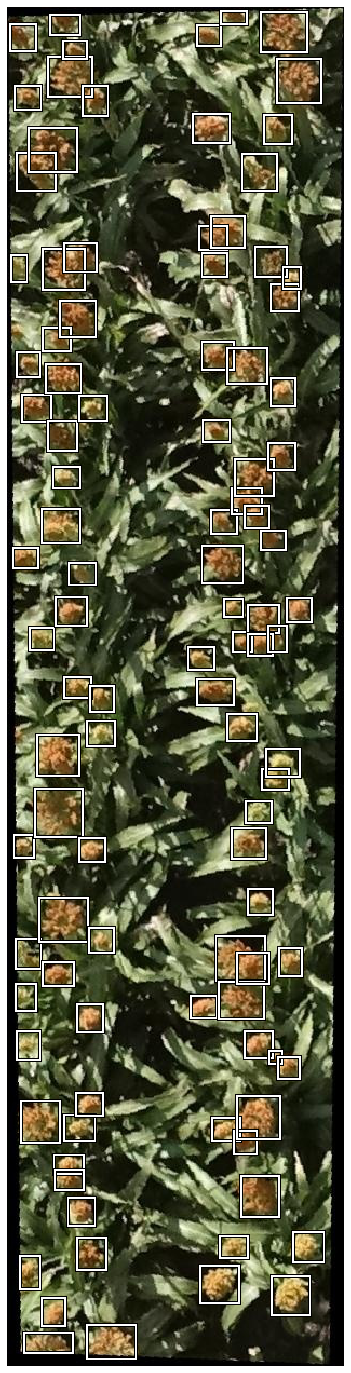

In [64]:
img = open_image(images[0])
classId = [0 for _ in range(len(lbl_bbox[0][0]))]
bbox = ImageBBox.create(*img.size, lbl_bbox[0][0], classId, classes=[''])
img.show(figsize=(25,25), y=bbox)

Many of the bounding boxes overlap. There is also a clear distinction between separate heads even when they're overlapping a considerable amount.